In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

from functools import partial

import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from src.models import (
    BayesianLinearRegression, 
    DeepQuantileRegression, QuantileLoss, 
    HeteroscedasticDropoutNet, gaussian_nll_loss
)
from src.models.quantile_utils import create_quantiles, get_quantile_pred

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
colnames = [
    'CRIM',      # per capita crime rate by town
    'ZN',        # proportion of residential land zoned for lots over 25,000 sq.ft.
    'INDUS',     # proportion of non-retail business acres per town
    'CHAS',      # Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
    'NOX',       # nitric oxides concentration (parts per 10 million)
    'RM',        # average number of rooms per dwelling
    'AGE',       # proportion of owner-occupied units built prior to 1940
    'DIS',       # weighted distances to five Boston employment centres
    'RAD',       # index of accessibility to radial highways
    'TAX',       # full-value property-tax rate per $10,000
    'PTRATIO',   # pupil-teacher ratio by town
    'B',         # 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
    'LSTAT',     # % lower status of the population
    'MEDV',      # Median value of owner-occupied homes in $1000's
]

In [3]:
df = pd.read_table('../data/raw/boston-housing/housing.data', header=None, names=colnames, delimiter="\s+")

In [4]:
col_x = [c for c in colnames if c != 'MEDV']
col_y = ['MEDV']

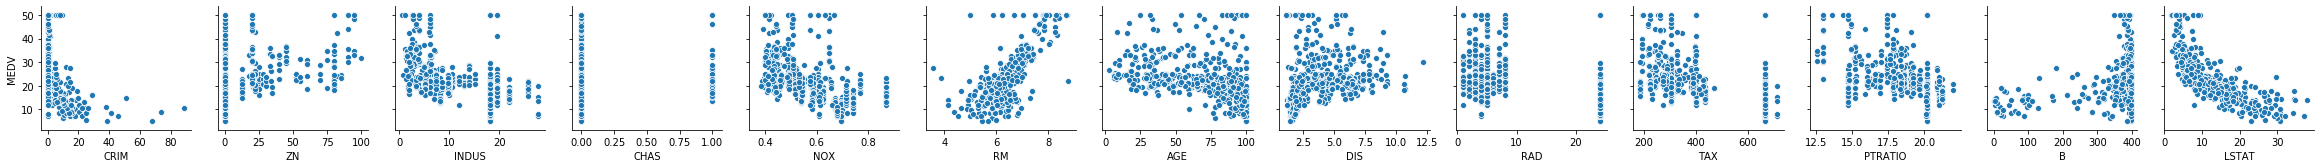

In [5]:
sns.pairplot(df, x_vars=col_x, y_vars=col_y)

In [172]:
x, x_test, y, y_test = train_test_split(df[col_x], df[col_y], test_size=.2)

In [173]:
blr = BayesianLinearRegression()

In [174]:
x_train, y_train = torch.tensor(x.values, dtype=torch.float32), torch.tensor(y.values, dtype=torch.float32)
x_val, y_val = torch.tensor(x_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32)

In [205]:
QUANTILES = create_quantiles(11, min_q=0.05, max_q=0.95)
qr_params = {
    'input_size': x_train.shape[1],
    'hidden_size': 64,
    'dropout_p': 0.05,
    'dropout_dim': 1,
    'quantiles': QUANTILES,
    'batch_size': 16,
    'epochs': 1001,
    'lr': 1e-4,
    'weight_decay': 1e-6,
}
dqr = DeepQuantileRegression(qr_params)
criterion = partial(QuantileLoss, quantiles=QUANTILES)

In [206]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, qr_params['batch_size'], shuffle=True)

In [207]:
# from torch import nn
# from src.models.mcdqrnn import Dropout_on_dim

In [208]:
dqr.model_ = nn.Sequential(
    nn.Linear(qr_params['input_size'], qr_params['hidden_size']),
    nn.PReLU(),
    Dropout_on_dim(qr_params['dropout_p'], dim=qr_params['dropout_dim']),
    nn.Linear(qr_params['hidden_size'], qr_params['hidden_size']),
    nn.PReLU(),
    Dropout_on_dim(qr_params['dropout_p'], dim=qr_params['dropout_dim']),
    nn.Linear(qr_params['hidden_size'], qr_params['hidden_size']),
    nn.PReLU(),
    Dropout_on_dim(qr_params['dropout_p'], dim=qr_params['dropout_dim']),
    nn.Linear(qr_params['hidden_size'], len(qr_params['quantiles']))
)

In [209]:
for epoch in range(qr_params['epochs']):
    for x_batch, y_batch in train_dl:
        dqr.train()
        preds = dqr(x_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        dqr.optim_.step()
        dqr.optim_.zero_grad()
    
    if epoch % 50 == 0:
        dqr.eval()
        with torch.no_grad():
            train_loss = criterion(dqr(x_train), y_train)
            val_loss = criterion(dqr(x_val), y_val)
        print(f"Epoch: {epoch} \t Train loss:{train_loss:.5f} \t Val loss: {val_loss:.5f}")

Epoch: 0 	 Train loss:109.28989 	 Val loss: 120.21312
Epoch: 50 	 Train loss:111.44809 	 Val loss: 115.73294
Epoch: 100 	 Train loss:111.59194 	 Val loss: 114.72437
Epoch: 150 	 Train loss:109.54815 	 Val loss: 118.61049
Epoch: 200 	 Train loss:112.79466 	 Val loss: 118.66854
Epoch: 250 	 Train loss:114.02518 	 Val loss: 122.63955
Epoch: 300 	 Train loss:108.08376 	 Val loss: 117.46773
Epoch: 350 	 Train loss:111.84059 	 Val loss: 123.72498
Epoch: 400 	 Train loss:109.21915 	 Val loss: 115.81877
Epoch: 450 	 Train loss:114.22153 	 Val loss: 122.67056


KeyboardInterrupt: 

In [210]:
qr_preds = dqr.mc_predict(x_train, samples=4000).numpy()
qr_preds.shape

(4000, 404, 11)

In [211]:
import matplotlib.pyplot as plt

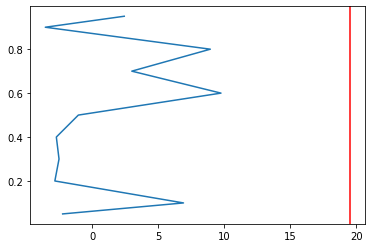

In [212]:
i = 1
plt.plot(np.mean(qr_preds, axis=0)[i], QUANTILES)
plt.axvline(y_train[i], c='r')